## Setup

In [2]:
!pip install -q hazm
!pip install -q clean-text[gpl]
!pip install -q persian_wordcloud
!pip install -q transformers

     |████████████████████████████████| 316 kB 5.3 MB/s 
     |████████████████████████████████| 1.4 MB 58.4 MB/s 
     |████████████████████████████████| 233 kB 54.7 MB/s 
     |████████████████████████████████| 170 kB 6.9 MB/s 
     |████████████████████████████████| 64 kB 2.6 MB/s 
     |████████████████████████████████| 235 kB 59.4 MB/s 
     |████████████████████████████████| 65 kB 2.3 MB/s 
     |████████████████████████████████| 3.4 MB 5.5 MB/s 
     |████████████████████████████████| 3.3 MB 40.7 MB/s 
     |████████████████████████████████| 895 kB 51.2 MB/s 
     |████████████████████████████████| 596 kB 58.6 MB/s 
     |████████████████████████████████| 67 kB 4.7 MB/s 


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from cleantext import clean
import hazm
import os
import re
import json
from persian_wordcloud.wordcloud import PersianWordCloud, add_stop_words
from IPython.display import Image
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

### Loading data

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Assignments/Snappfood dataset/train.csv', encoding='utf-8', sep='\t')
df = df[['comment', 'label', 'label_id']]

In [6]:
df_val = pd.read_csv('/content/drive/MyDrive/Assignments/Snappfood dataset/dev.csv', encoding='utf-8', sep='\t')
df_val = df_val[['comment', 'label', 'label_id']]

In [7]:
df_test = pd.read_csv('/content/drive/MyDrive/Assignments/Snappfood dataset/test.csv', encoding='utf-8', sep='\t')
df_test = df_test[['comment', 'label', 'label_id']]

In [8]:
df.head()

,comment,label,label_id
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0
4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0


In [9]:
df.shape

(56700, 3)

## Preprocessing

### Missing values and imbalanced data

In [10]:
# Checking information and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56700 entries, 0 to 56699
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comment   56700 non-null  object
 1   label     56700 non-null  object
 2   label_id  56700 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


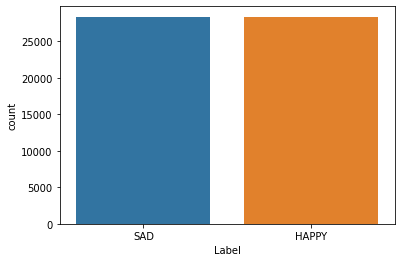

In [11]:
# Checking label distribuation
sns.countplot(df['label'])
plt.xlabel('Label');

[OK] Dataset is balanced and has no missing values

## Data Cleaning

In [12]:
def clean_html(s):
    return re.sub(re.compile('<.*?>'), '', s)
    
def text_preprocessing(s):
  s = s.strip()
  s = clean(s,
    fix_unicode=True,               # fix various unicode errors
    to_ascii=False,                  # transliterate to closest ASCII representation
    lower=True,                     # lowercase text
    no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
    no_urls=True,                  # replace all URLs with a special token
    no_emails=True,                # replace all email addresses with a special token
    no_phone_numbers=True,         # replace all phone numbers with a special token
    no_numbers=False,               # replace all numbers with a special token
    no_digits=False,                # replace all digits with a special token
    no_currency_symbols=False,      # replace all currency symbols with a special token
    no_punct=False,                 # remove punctuations
    replace_with_punct="",          # instead of removing punctuations you may replace them
    replace_with_url="",
    replace_with_email="",
    replace_with_phone_number="",
    replace_with_number="",
    replace_with_digit="0",
    replace_with_currency_symbol="",
)
  
  s = clean_html(s)

  normalizer = hazm.Normalizer()
  s = normalizer.normalize(s)

  extra_characters = re.compile("["
    u"\U0001F600-\U0001F64F"  
    u"\U0001F300-\U0001F5FF"  
    u"\U0001F680-\U0001F6FF"  
    u"\U0001F1E0-\U0001F1FF"  
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u'\U00010000-\U0010ffff'
    u"\u200d"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\u3030"
    u"\ufe0f"
    u"\u2069"
    u"\u2066"
    u"\u2068"
    u"\u2067"
    "]+", flags=re.UNICODE)

  s = extra_characters.sub(r'', s)
  s = re.sub("\s+", " ", s)         # trailing whitespace
  s = re.sub(r'(@.*?)[\s]', ' ', s) # @ mentions
  s = re.sub("#", "", s)            # hashtags

  return s


In [13]:
df['cleaned_comment'] = df['comment'].apply(text_preprocessing)

In [14]:
df_val['cleaned_comment'] = df_val['comment'].apply(text_preprocessing)

In [15]:
df_test['cleaned_comment'] = df_test['comment'].apply(text_preprocessing)

In [16]:
df

,comment,label,label_id,cleaned_comment
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0,عالللی بود همه چه درست و به اندازه و کیفیت خوب...
4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0,شیرینی وانیلی فقط یک مدل بود.
...,...,...,...,...
56695,یک تیکه کم فرستاده بودن و با تماس من در کمترین...,HAPPY,0,یک تیکه کم فرستاده بودن و با تماس من در کمترین...
56696,عالی بود همه چیز ممنونم پیک هم خیلی مرتب و به ...,HAPPY,0,عالی بود همه چیز ممنونم پیک هم خیلی مرتب و به ...
56697,مثل همیشه عالی، من چندمین باره سفارش میدم و هر...,HAPPY,0,مثل همیشه عالی، من چندمین باره سفارش میدم و هر...
56698,دلستر استوایی خواسته بودم اما لیمویی فرستادند,HAPPY,0,دلستر استوایی خواسته بودم اما لیمویی فرستادند


## Exploratory data analysis

### Wordcloud for happy comments (label_id == 0)

In [17]:
# Wordcloud for happy comments (label_id == 0)

stopwords = add_stop_words(['رو'])
# add_stop_words

# Generate a word cloud image
wordcloud = PersianWordCloud(
    only_persian=True,
    max_words=150,
    stopwords=stopwords,
    margin=0,
    width=500,
    height=500,
    min_font_size=1,
    max_font_size=500,
    background_color="black"
).generate(" ".join(df[df.label_id == 0].cleaned_comment))

image = wordcloud.to_image()
#image.show()
image.save('result.png')

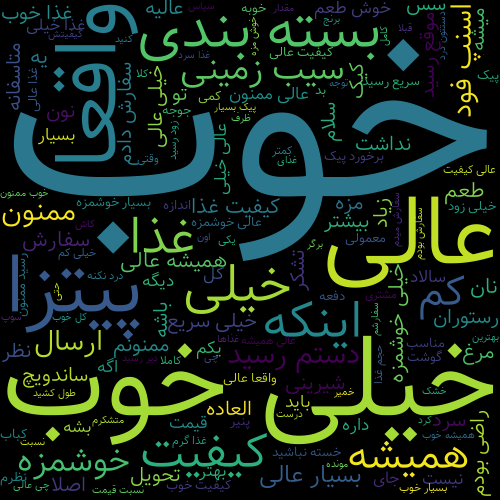

In [18]:
Image('result.png', width=500, height=500)

### Wordcloud for sad comments (label_id == 1)

In [19]:
# Generate a word cloud image
wordcloud = PersianWordCloud(
    only_persian=True,
    max_words=150,
    stopwords=stopwords,
    margin=0,
    width=500,
    height=500,
    min_font_size=1,
    max_font_size=500,
    background_color="black"
).generate(" ".join(df[df.label_id == 1].cleaned_comment))

image = wordcloud.to_image()
#image.show()
image.save('result-sad.png')

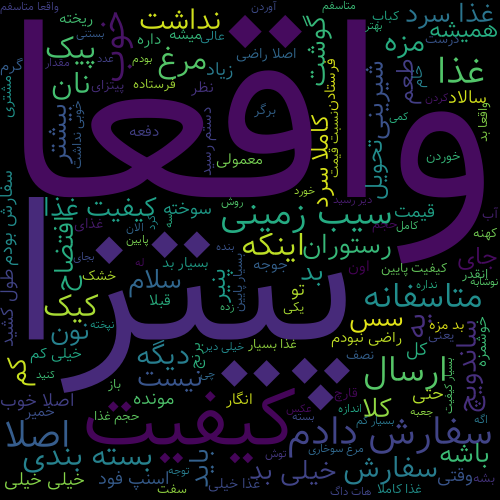

In [20]:
Image('result-sad.png', width=500, height=500)

### Number of word in each comment

In [21]:
# adding new coloumn to dataset - comment length by word
df['comment_length'] = df['cleaned_comment'].apply(lambda t: len(hazm.word_tokenize(t)))

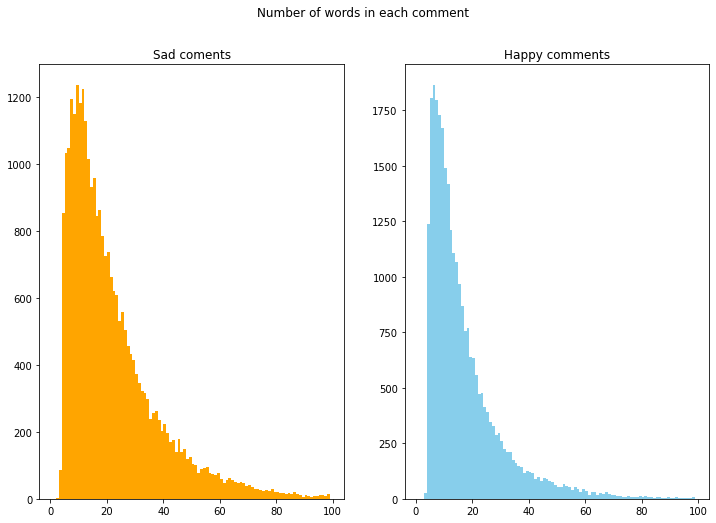

In [22]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,8))
comment_len = df[df['label_id']==1]['comment_length']
ax1.hist(comment_len,color='orange', bins=range(1,100))
ax1.set_title('Sad coments')

comment_len = df[df['label_id']==0]['comment_length']
ax2.hist(comment_len,color='skyblue', bins=range(1,100))
ax2.set_title('Happy comments')

fig.suptitle('Number of words in each comment')
plt.show()

# Machine Learning models



In [23]:
# creating a map list for labels and label_ids
all_labels = list(sorted(df['label'].unique()))
label2id = {label: i for i, label in enumerate(all_labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'HAPPY': 0, 'SAD': 1}
id2label: {0: 'HAPPY', 1: 'SAD'}


In [24]:
# Train and test feature vectors

tfidf = TfidfVectorizer(ngram_range=(1, 3), min_df=3, sublinear_tf=True)
features = tfidf.fit_transform(df['cleaned_comment'])
test_features = tfidf.transform(df_test['cleaned_comment'])
labels = df['label']
test_labels = df_test['label']
features.shape

(56700, 89919)

In [25]:
# To select a smaller set of features

# from sklearn.feature_selection import SelectPercentile, f_classif
# selector = SelectPercentile(f_classif, percentile=10)
# selector.fit(features, labels)
# features_train = selector.transform(features).toarray()

## Model Selection

In [26]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

In [27]:
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

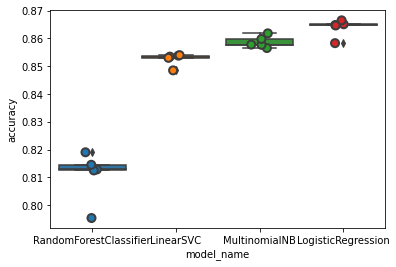

In [28]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [29]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.852540
LogisticRegression        0.863862
MultinomialNB             0.858713
RandomForestClassifier    0.810882
Name: accuracy, dtype: float64

Continue with the model: LogisticRegression

## Model Evaluation

In [30]:
id2label.values()

dict_values(['HAPPY', 'SAD'])

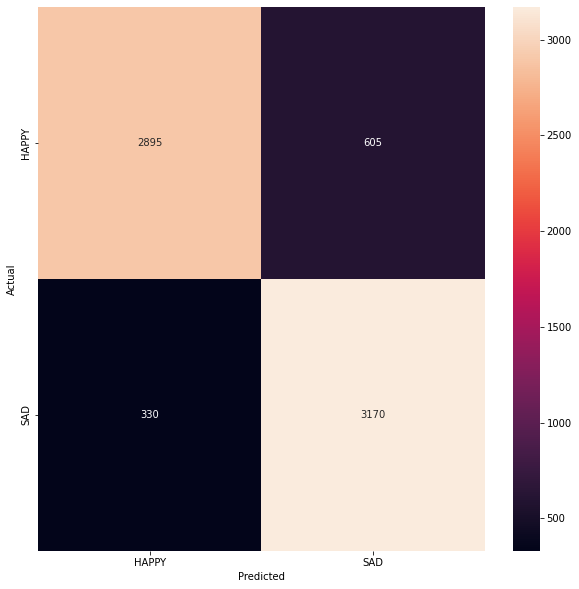

In [31]:
model = LogisticRegression()
model.fit(features, labels)
pred_labels = model.predict(test_features)


conf_mat = confusion_matrix(test_labels, pred_labels)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=id2label.values(), yticklabels=id2label.values())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [32]:
# Model Classification Report
print(metrics.classification_report(test_labels, pred_labels, target_names=df['label'].unique()))

              precision    recall  f1-score   support

         SAD       0.90      0.83      0.86      3500
       HAPPY       0.84      0.91      0.87      3500

    accuracy                           0.87      7000
   macro avg       0.87      0.87      0.87      7000
weighted avg       0.87      0.87      0.87      7000



### Saving tfidf vector

In [33]:
import pickle
tfidf_filename = '/content/drive/MyDrive/Assignments/Sentiment analysis/tfidf.pkl'
model_filename = '/content/drive/MyDrive/Assignments/Sentiment analysis/LR_model.pkl'

In [34]:
pickle.dump(tfidf, open(tfidf_filename, 'wb'))
pickle.dump(model, open(model_filename, 'wb'))

In [35]:
#tfidf = pickle.load(open(tfidf_filename, 'rb'))

# ParsBert

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cpu
CUDA is not available.  Training on CPU ...


## Config

In [38]:
# general config
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16

EPOCHS = 3
EEVERY_EPOCH = 1000
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/drive/MyDrive/Assignments'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [39]:
# tokenizer config
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())

Downloading:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440 [00:00<?, ?B/s]

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "HAPPY",
    "1": "SAD"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "HAPPY": 0,
    "SAD": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.15.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}



### Choosing Max Sequence Length

In [40]:
token_lens = []

for txt in df.cleaned_comment:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

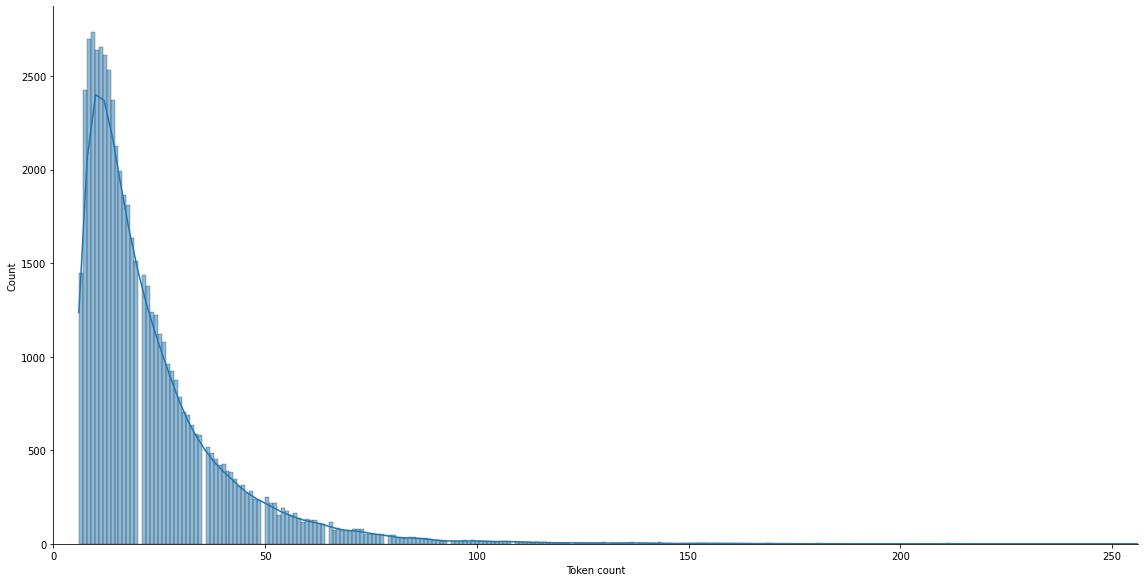

In [41]:
sns.displot(token_lens, kde=True, height=8, aspect=2)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the comments appear to be less than 100 tokens long, but we'll be careful and set a maximum length of 128.

In [42]:
MAX_LEN = 128

## Dataset preparation

In [71]:
class SanppfoodDataset(Dataset):

  def __init__(self, comments, targets, tokenizer, max_len):
    self.comments = comments
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.comments)
  
  def __getitem__(self, item):
    comment = self.comments[item]
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      comment,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=True,
      truncation=True,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'comment': comment,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'token_type_ids': encoding['token_type_ids'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [72]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = SanppfoodDataset(
    comments=df.cleaned_comment.to_numpy(),
    targets=df.label_id.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size
  )

In [73]:
df.shape, df_val.shape, df_test.shape

((56700, 5), (6300, 4), (7000, 4))

In [74]:
# Creating data loaders
BATCH_SIZE = 8

train_data_loader = create_data_loader(df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [75]:
data_sample = next(iter(train_data_loader))
data_sample.keys()

dict_keys(['comment', 'input_ids', 'attention_mask', 'token_type_ids', 'targets'])

In [76]:
print(data_sample['input_ids'].shape)
print(data_sample['attention_mask'].shape)
print(data_sample['targets'].shape)

torch.Size([8, 128])
torch.Size([8, 128])
torch.Size([8])


## Building model

In [91]:
class SentimentModel(nn.Module):

    def __init__(self, config):
        super(SentimentModel, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH, return_dict=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids)
        
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits 

In [68]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
parsbert_model = None

In [92]:
parsbert_model = SentimentModel(config=config)
parsbert_model = parsbert_model.to(device)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [93]:
input_ids = data_sample['input_ids'].to(device)
attention_mask = data_sample['attention_mask'].to(device)
token_type_ids = data_sample['token_type_ids'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length
print(token_type_ids.shape) # batch size x seq length

torch.Size([8, 128])
torch.Size([8, 128])
torch.Size([8, 128])


In [95]:
# Predicted probabilities from the trained model
F.softmax(parsbert_model(input_ids, attention_mask, token_type_ids), dim=1)

tensor([[0.8011, 0.1989],
        [0.6299, 0.3701],
        [0.7797, 0.2203],
        [0.7433, 0.2567],
        [0.6657, 0.3343],
        [0.7483, 0.2517],
        [0.8259, 0.1741],
        [0.5216, 0.4784]], grad_fn=<SoftmaxBackward0>)

## Training phase

In [101]:
EPOCHS = 4

optimizer = AdamW(parsbert_model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [103]:
# Train model for one epoch
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in tqdm(data_loader, total=len(data_loader), desc="Training... "):

    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d['token_type_ids'].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [104]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d['token_type_ids'].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [110]:
from collections import defaultdict
from tqdm.notebook import tqdm

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    parsbert_model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    parsbert_model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(parsbert_model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Evaluation

In [ ]:
test_acc, _ = eval_model(
  parsbert_model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()